In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def derive_n(ds_T): # Derive atmospheric number density - particles cm^-3 (take care with units!)

    ds_n = xr.Dataset()
    # Conversion constants
    k = 1.380649e-23 # Boltzmann constant J K^-1 = kg m^2 s^-2 K^-1
    to_cm3 = 1e6 # convertion from m^3 to cm^3
    to_Pa = 100 # convert from hPa to Pa. Pa = kg m^-1 s^-2
    ds_n['n'] = ds_T['lev']*to_Pa/(to_cm3*k*ds_T) # Units: kg m^-1 s^-2 * kg^-1 m^-2 s^2 K * K^-1 = m^-3 | m^-3 * 1e-6 = cm^-3
    
    return ds_n

In [5]:
path = '../../data/processed_data/monthly_domain_average/'
filestr = 'on_lev_nonrr_night_cm' # options nonrr_diur_cm, nonrr_night_cm, rr_diur_cm, rr_night_cm
ds_in = xr.open_mfdataset(path+ f'{filestr}*')


In [6]:
# Convert mixing ratios to density
variables_for_n = ['O','O3'] # day time = ['O','NO','CO2','CO','H2O'] # Night time = ['O','O3']
ds_on_lev = ds_in
for var in variables_for_n:
    ds_on_lev[f'{var}_n'] = ds_in[var]*derive_n(ds_in['T'])['n']

In [ ]:
##################################################################
######################
######################
######################
######################

In [7]:
# Inspect file and write to netcdf
ds_on_lev
# ds_on_lev.to_netcdf(f'./processed_data/on_lev_{filestr}_2010.nc')

<xarray.Dataset> Size: 54kB
Dimensions:  (lev: 110, time: 12)
Coordinates:
  * lev      (lev) float64 880B 6.14e-06 9.453e-06 1.455e-05 ... 976.3 992.6
  * time     (time) int64 96B 201001 201002 201003 ... 201010 201011 201012
Data variables:
    O        (time, lev) float64 11kB dask.array<chunksize=(12, 110), meta=np.ndarray>
    O3       (time, lev) float64 11kB dask.array<chunksize=(12, 110), meta=np.ndarray>
    lat      (time) float64 96B dask.array<chunksize=(12,), meta=np.ndarray>
    lon      (time) float64 96B dask.array<chunksize=(12,), meta=np.ndarray>
    T        (time, lev) float64 11kB dask.array<chunksize=(12, 110), meta=np.ndarray>
    O_n      (time, lev) float64 11kB dask.array<chunksize=(12, 110), meta=np.ndarray>
    O3_n     (time, lev) float64 11kB dask.array<chunksize=(12, 110), meta=np.ndarray>

In [8]:
# Integrate hydrostatic approximation to get GPH if not already in dataset (don't use if not needed)
import sys
sys.path.append('../../helpers/')
import P_to_GPH_ncol
import importlib
importlib.reload(P_to_GPH_ncol)
p2gph = P_to_GPH_ncol.P_to_GPH_ncol

ds_with_z = p2gph(ds_on_lev)

Integrating it, 11  ncol  0  lev  0  progress  99.17  %   
That took  29.04 seconds


In [9]:
# Inspect ds generated in above cell
ds_with_z

<xarray.Dataset> Size: 75kB
Dimensions:  (lev: 110, time: 12)
Coordinates:
  * lev      (lev) float64 880B 6.14e-06 9.453e-06 1.455e-05 ... 976.3 992.6
  * time     (time) int64 96B 201001 201002 201003 ... 201010 201011 201012
Data variables:
    O        (time, lev) float64 11kB dask.array<chunksize=(12, 110), meta=np.ndarray>
    O3       (time, lev) float64 11kB dask.array<chunksize=(12, 110), meta=np.ndarray>
    lat      (time) float64 96B dask.array<chunksize=(12,), meta=np.ndarray>
    lon      (time) float64 96B dask.array<chunksize=(12,), meta=np.ndarray>
    T        (time, lev) float64 11kB dask.array<chunksize=(12, 110), meta=np.ndarray>
    O_n      (time, lev) float64 11kB dask.array<chunksize=(12, 110), meta=np.ndarray>
    O3_n     (time, lev) float64 11kB dask.array<chunksize=(12, 110), meta=np.ndarray>
    gph      (time, lev) float64 11kB 134.7 128.2 122.4 ... 0.2934 0.1345 0.0
    z        (time, lev) float64 11kB 137.6 130.9 124.8 ... 0.2934 0.1345 0.0

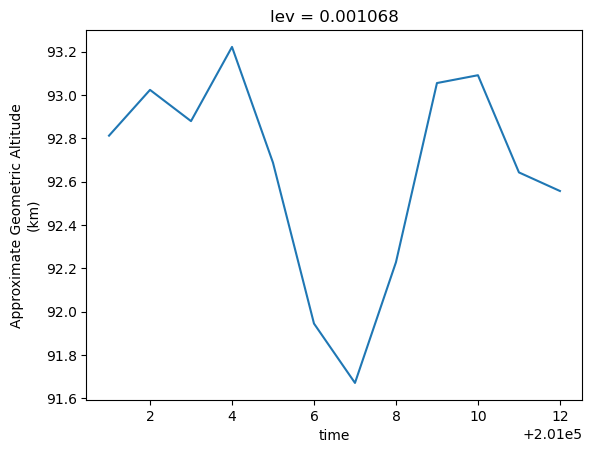

In [13]:
ds_with_z['z'].sel(lev=1e-3,method='nearest').plot()

In [14]:
# Select dataset for interpolation onto common altitude
ds_for_interp = ds_with_z
# ds_for_interp = ds_on_lev

In [15]:
# Interpolate to common altitude
z_interp=np.arange(135,0,-2.5)
ds_out = []
for itime in range(12):
    ds_temp = ds_for_interp.isel(time=itime).swap_dims({'lev':'z'}).reset_coords("lev").interp(z=z_interp)
    ds_out.append(ds_temp)
ds_on_z = xr.concat(ds_out,dim='time')

In [17]:
ds_on_z

<xarray.Dataset> Size: 37kB
Dimensions:  (time: 12, z: 54)
Coordinates:
  * time     (time) int64 96B 201001 201002 201003 ... 201010 201011 201012
  * z        (z) float64 432B 135.0 132.5 130.0 127.5 125.0 ... 10.0 7.5 5.0 2.5
Data variables:
    lev      (time, z) float64 5kB 7.412e-06 8.649e-06 1.019e-05 ... 525.4 727.2
    O        (time, z) float64 5kB dask.array<chunksize=(1, 54), meta=np.ndarray>
    O3       (time, z) float64 5kB dask.array<chunksize=(1, 54), meta=np.ndarray>
    lat      (time) float64 96B dask.array<chunksize=(1,), meta=np.ndarray>
    lon      (time) float64 96B dask.array<chunksize=(1,), meta=np.ndarray>
    T        (time, z) float64 5kB dask.array<chunksize=(1, 54), meta=np.ndarray>
    O_n      (time, z) float64 5kB dask.array<chunksize=(1, 54), meta=np.ndarray>
    O3_n     (time, z) float64 5kB dask.array<chunksize=(1, 54), meta=np.ndarray>
    gph      (time, z) float64 5kB 132.2 129.8 127.4 125.0 ... 7.491 4.996 2.499

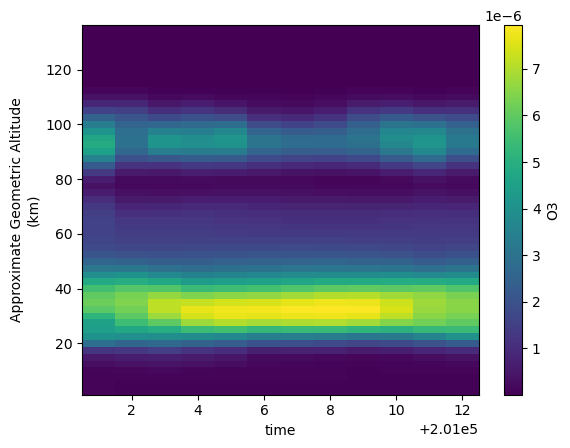

In [22]:
# Inspect 
ds_on_z['O3'].plot(y='z')

In [41]:
# Write on z file to netcdf
ds_on_z.to_netcdf(f'./processed_data/on_z_{filestr}_2010.nc')